# Importing Necessary Libraries

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

# Functions of y1 and y2 for checking y_loss

In [35]:
def f_y_1(x0, x1):
    return torch.cos(49 * x0 + 63 * x1)

def f_y_2(x0, x1):
    return torch.cos(4 * x0 + 8 * x1)

# Hyperparameters

In [36]:
number_of_points = 50
in_channels1 = 1
out_channels1 = 16
kernel_size1 = (16, 2) 
out_channels2 = 32
kernel_size2 = (8, 2)
out_channels3 = 64
kernel_size3 = (4, 2)
kernel_size4 = (16,2)
padding = (0, 1)
dimInt = (number_of_points-kernel_size1[0]+1-kernel_size2[0]+1-kernel_size3[0]+1)
latent_dim = 800
hidden_dim = 100
batch_size = 32

# Model Architecture

In [37]:
class Encoder(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim):
        super(Encoder, self).__init__()
        
        self.C1 = nn.Conv2d(in_channels1, out_channels1, kernel_size=kernel_size1)
        self.relu = nn.ReLU()

        self.C2 = nn.Conv2d(out_channels1, out_channels2, kernel_size=kernel_size2)
        self.tanh = nn.Tanh()

        self.C3 = nn.Conv2d(out_channels2, out_channels3, kernel_size=kernel_size3)
        
        self.mu = nn.Linear(out_channels3 * dimInt, latent_dim)
        
        self.log_var = nn.Linear(out_channels3 * dimInt, latent_dim)
        
    def forward(self, x, cond):

        # print(x.shape, cond.shape)
        x_ = torch.cat([x, cond], dim=3)
        # print(x_.shape)

        x_ = self.relu(self.C1(x_))
        # print(x_.shape)

        x_ = self.tanh(self.C2(x_))
        # print(x_.shape)

        x_ = self.relu(self.C3(x_))
        # print(x_.shape)

        x_ = x_.view(x_.shape[0], -1)
        # print(x_.shape)
        
        z_mu = self.mu(x_)
        # print(z_mu.shape)
        
        z_log_var = self.log_var(x_)
        # print(z_log_var.shape)

        return z_mu, z_log_var

In [38]:
class Sampling(nn.Module):
    def __init__(self):
        super(Sampling, self).__init__()

    def forward(self, z_mu, z_log_var):
        
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        
        
        # print((z_mu + eps * std).shape)
        
        return z_mu + eps * std

In [39]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding):
        super(Decoder, self).__init__()

        self.L1 = nn.Linear(latent_dim, hidden_dim)
        self.relu = nn.ReLU()

        self.L2 = nn.Linear(2*hidden_dim, out_channels3 * dimInt)
        self.tanh = nn.Tanh()

        self.CT1 = nn.ConvTranspose2d(out_channels3, out_channels2, kernel_size=kernel_size3)

        self.CT2 = nn.ConvTranspose2d(out_channels2, out_channels1, kernel_size=kernel_size2)

        self.CT3 = nn.ConvTranspose2d(out_channels1, in_channels1, kernel_size=kernel_size4,  padding=padding)


        
        self.number_of_points = number_of_points
    def forward(self, x, cond):
        
        # print(x.shape)
        # print(cond.shape)
        x = self.relu(self.L1(x))
        # print(x.shape)
        
        cond = torch.reshape(cond, (len(cond), self.number_of_points * 2))
        # print(cond.shape)
        x = torch.cat([x, cond], dim=1)
        # print(x.shape)

        x = self.tanh(self.L2(x))
        # print(x.shape)
        
        x = x.view(x.shape[0], out_channels3, -1, 1)
        # print(x.shape)

        x = self.relu(self.CT1(x))
        # print(x.shape)

        x = self.relu(self.CT2(x))
        # print(x.shape)
        
        x = self.relu(self.CT3(x))
        # print(x.shape)

        return x

In [40]:
class CVAE(nn.Module):
    def __init__(self, in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding):
        super(CVAE, self).__init__()
        self.encoder = Encoder(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim)
        self.sampling = Sampling()
        self.decoder = Decoder(latent_dim, hidden_dim, number_of_points, out_channels3, dimInt, out_channels2, kernel_size3, out_channels1, kernel_size2, in_channels1, kernel_size4, padding)

    def forward(self, x, cond):
        z_mu, z_log_var = self.encoder(x, cond)

        z = self.sampling(z_mu, z_log_var)

        x_hat = self.decoder(z, cond)

        return z_mu, z_log_var, x_hat
        

In [41]:
Model = CVAE(in_channels1, out_channels1, kernel_size1, out_channels2, kernel_size2, out_channels3, kernel_size3, dimInt, latent_dim, hidden_dim, number_of_points, kernel_size4, padding)

# Loading the dataset into train Loader

In [42]:
train_dataset = torch.load('/kaggle/input/bh-data-2/train_dataset.pt')
X0_X1, Y1_Y2 = train_dataset.tensors
X0_X1.shape, Y1_Y2.shape

(torch.Size([100000, 1, 50, 2]), torch.Size([100000, 1, 50, 2]))

In [43]:
Train_Dataset = TensorDataset(X0_X1, Y1_Y2)
train_loader = DataLoader(Train_Dataset, batch_size=batch_size, shuffle=True)

# Defining loss function

In [44]:
def loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2):
    
    recon_loss_fn = torch.nn.L1Loss(reduction='mean')
    
    x_loss = recon_loss_fn(x0_x1, x_hat)
    x_loss = x_loss * 2
    
    KLD = -0.5 * torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

    x0 = x_hat[:,:,:,0]
    x1 = x_hat[:,:,:,1]
    y1 = f_y_1(x0, x1)
    y2 = f_y_2(x0, x1)
    y1 = y1.view(-1, 1, 50, 1)
    y2 = y2.view(-1, 1, 50, 1)
    y_hat = torch.cat([y1, y2], dim=3)
    y_loss = recon_loss_fn(y1_y2, y_hat)
    
    
    return x_loss, KLD, y_loss, x_loss + KLD + y_loss

# Function to generate samples

In [45]:
def generate_samples(num_samples, given_y):
    samples = torch.tensor([])
    samples = samples.to(device)
    givens = torch.tensor([])
    givens = givens.to(device)
    given_y = given_y.to(device)
    Model.eval()
    with torch.no_grad():
        for i, _ in enumerate(range(num_samples)):
            z_rand = torch.randn(1, 50, 2)
            z_rand = z_rand.to(device)
            z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), given_y[i,:,:,:].unsqueeze(0))
            z = Model.sampling(z_mu, z_log_var)
            
            sample = Model.decoder(z, given_y[i,:,:,:])
            samples = torch.cat([samples, sample], dim=0)   
            
    givens = torch.cat([givens, given_y], dim=0) 

    return samples, givens

# GPU setup

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [47]:
Model.to(device)

CVAE(
  (encoder): Encoder(
    (C1): Conv2d(1, 16, kernel_size=(16, 2), stride=(1, 1))
    (relu): ReLU()
    (C2): Conv2d(16, 32, kernel_size=(8, 2), stride=(1, 1))
    (tanh): Tanh()
    (C3): Conv2d(32, 64, kernel_size=(4, 2), stride=(1, 1))
    (mu): Linear(in_features=1600, out_features=800, bias=True)
    (log_var): Linear(in_features=1600, out_features=800, bias=True)
  )
  (sampling): Sampling()
  (decoder): Decoder(
    (L1): Linear(in_features=800, out_features=100, bias=True)
    (relu): ReLU()
    (L2): Linear(in_features=200, out_features=1600, bias=True)
    (tanh): Tanh()
    (CT1): ConvTranspose2d(64, 32, kernel_size=(4, 2), stride=(1, 1))
    (CT2): ConvTranspose2d(32, 16, kernel_size=(8, 2), stride=(1, 1))
    (CT3): ConvTranspose2d(16, 1, kernel_size=(16, 2), stride=(1, 1), padding=(0, 1))
  )
)

# Function to plot samples

In [48]:
def plot_samples(num_samples, x0_x1, y1_y2):
    x0_x1 = x0_x1.to("cpu")
    y1_y2 = y1_y2.to("cpu")
    for i in range(num_samples):
        
        x0 = x0_x1[i,0,:,0]
        x1 = x0_x1[i,0,:,1]
        y1 = y1_y2[i,0,:,0]
        y2 = y1_y2[i,0,:,1]
        y1_hat = f_y_1(x0, x1)
        y2_hat = f_y_2(x0, x1)
        plt.plot(x0.detach().numpy(), label="X0")
        plt.plot(x1.detach().numpy(), label="X1")
        plt.plot(y1.detach().numpy(), label="Y1")
        plt.plot(y2.detach().numpy(), label="Y2")
        plt.plot(y1_hat.detach().numpy(), label="Y1_hat")
        plt.plot(y2_hat.detach().numpy(), label="Y2_hat")
        plt.legend()
        plt.show()

# Plotting some examples

In [49]:
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    break

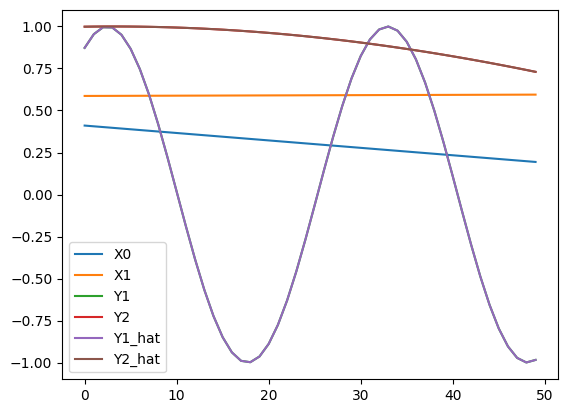

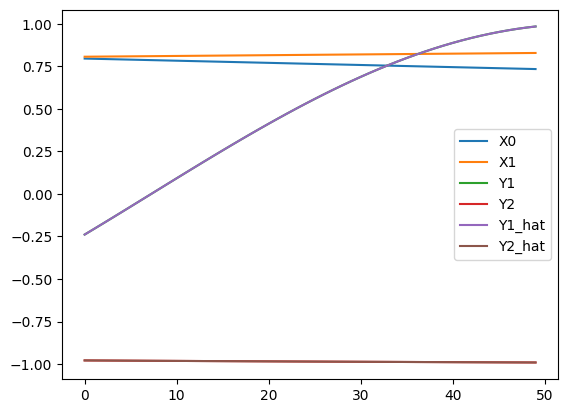

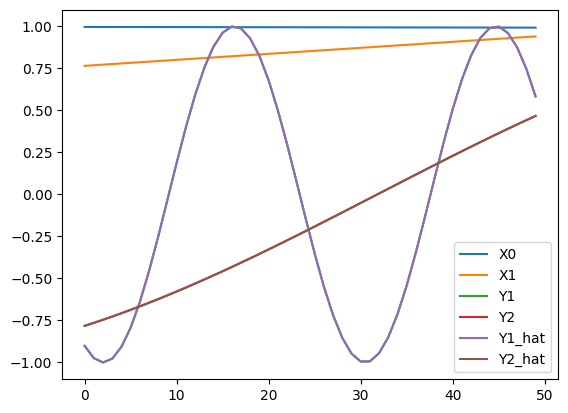

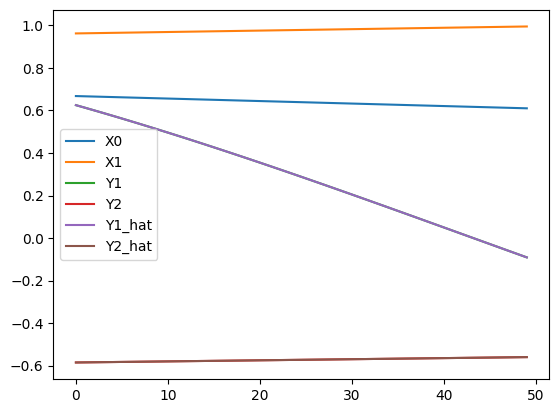

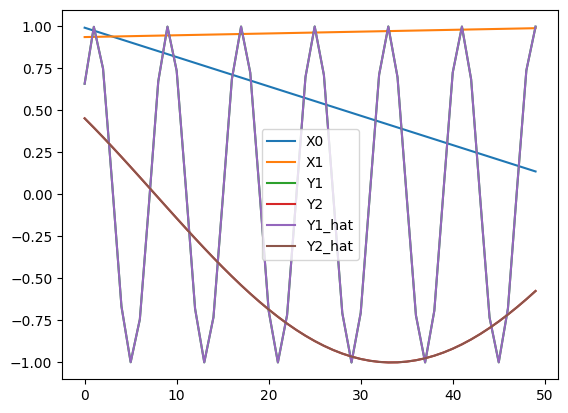

In [50]:
num_samples=5
plot_samples(num_samples, x1_x2, y1_y2)

In [51]:
num_samples = 5
for batch in train_loader:
    x1_x2, y1_y2 = batch 
    y_givens = y1_y2[:5,:,:,:]
    break

**Plot samples generated from untrained model**


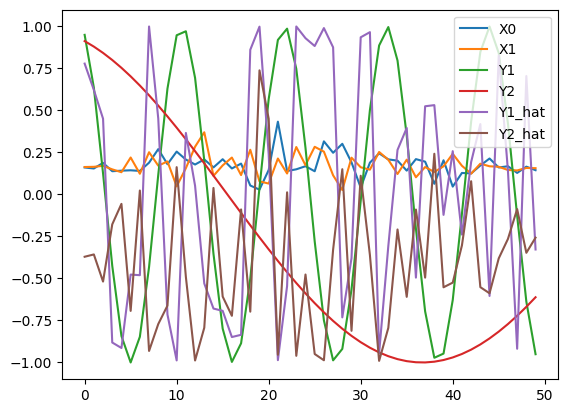

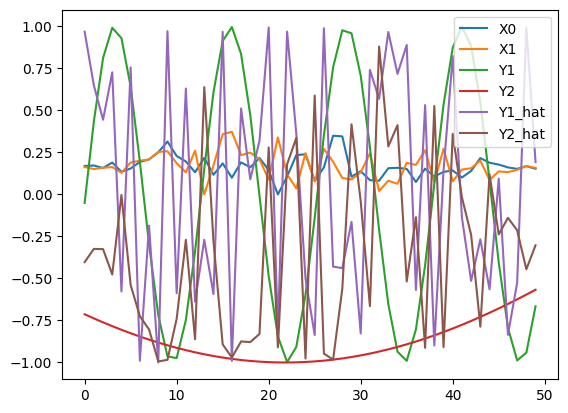

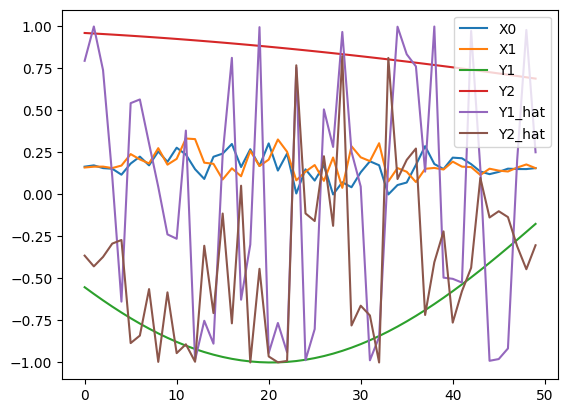

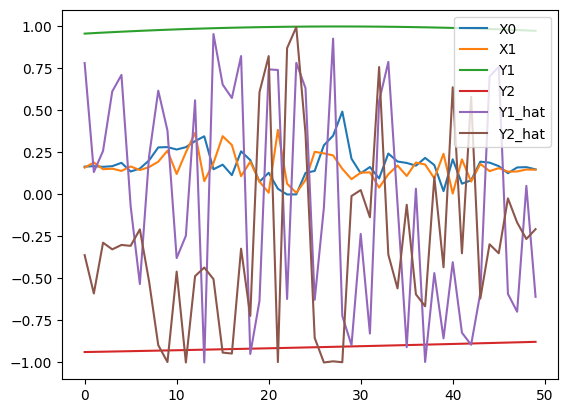

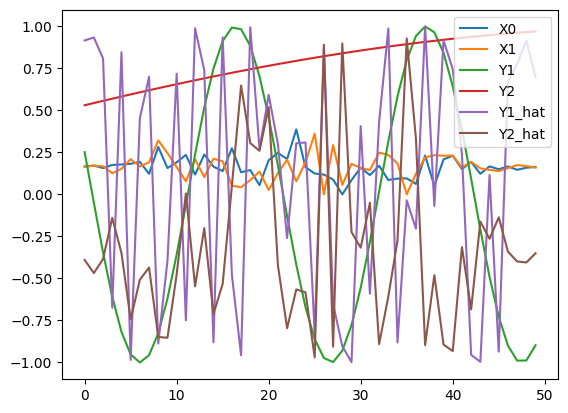

In [52]:
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Setting up optimizer and learning rate scheduler

In [53]:
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [54]:
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)

# Model Training

In [55]:
loss_ = []

epochs = 40

for epoch in range(epochs):
    running_x_loss = 0
    running_y_loss = 0
    running_KLD = 0
    running_loss = 0
    
    for batch in tqdm(train_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        Model.train()  
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        running_loss += loss.item()
        running_y_loss += y_loss.item()
        running_x_loss += x_loss.item()
        running_KLD += KLD.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    running_KLD = running_KLD / len(train_loader)
    running_loss = running_loss / len(train_loader)
    running_y_loss = running_y_loss / len(train_loader)
    running_x_loss = running_x_loss / len(train_loader)
    scheduler.step()
    
    loss_.append(running_loss)
    
    print(f'{epoch + 1}/{epochs} Loss: {running_loss} KLD: {running_KLD} y_loss: {running_y_loss} x_loss: {running_x_loss}')


  0%|          | 0/3125 [00:00<?, ?it/s]

1/40 Loss: 0.9432546451759338 KLD: 0.02016072509765625 y_loss: 0.47641712990760804 x_loss: 0.4466767900943756


  0%|          | 0/3125 [00:00<?, ?it/s]

2/40 Loss: 0.7050296213531494 KLD: 0.0003042502403259277 y_loss: 0.2711425711965561 x_loss: 0.43358280011177064


  0%|          | 0/3125 [00:00<?, ?it/s]

3/40 Loss: 0.6610131449699402 KLD: 0.0008111709690093994 y_loss: 0.2233055141210556 x_loss: 0.4368964598274231


  0%|          | 0/3125 [00:00<?, ?it/s]

4/40 Loss: 0.6419099862861634 KLD: 0.0012215675926208495 y_loss: 0.202618560461998 x_loss: 0.4380698586845398


  0%|          | 0/3125 [00:00<?, ?it/s]

5/40 Loss: 0.6334013561058044 KLD: 0.0015568539428710937 y_loss: 0.19463187666416168 x_loss: 0.4372126253604889


  0%|          | 0/3125 [00:00<?, ?it/s]

6/40 Loss: 0.6275600593376159 KLD: 0.0013511172485351562 y_loss: 0.18811277374744415 x_loss: 0.4380961685752869


  0%|          | 0/3125 [00:00<?, ?it/s]

7/40 Loss: 0.6238487398719788 KLD: 0.0020753900146484373 y_loss: 0.1839496107673645 x_loss: 0.4378237392807007


  0%|          | 0/3125 [00:00<?, ?it/s]

8/40 Loss: 0.6232728467750549 KLD: 0.0017133981323242187 y_loss: 0.1856221780490875 x_loss: 0.4359372704410553


  0%|          | 0/3125 [00:00<?, ?it/s]

9/40 Loss: 0.6252699463653565 KLD: 0.0025362899780273437 y_loss: 0.1859098589372635 x_loss: 0.4368237971782684


  0%|          | 0/3125 [00:00<?, ?it/s]

10/40 Loss: 0.6249385270690918 KLD: 0.0021048883056640627 y_loss: 0.1819577064180374 x_loss: 0.44087593167304995


  0%|          | 0/3125 [00:00<?, ?it/s]

11/40 Loss: 0.6184439010238647 KLD: 0.0019523452758789062 y_loss: 0.17482761499881744 x_loss: 0.44166394043922425


  0%|          | 0/3125 [00:00<?, ?it/s]

12/40 Loss: 0.6137839259147644 KLD: 0.002383441162109375 y_loss: 0.17034798544883728 x_loss: 0.4410524995326996


  0%|          | 0/3125 [00:00<?, ?it/s]

13/40 Loss: 0.6100952400398254 KLD: 0.001538990478515625 y_loss: 0.16896169912338257 x_loss: 0.4395945506954193


  0%|          | 0/3125 [00:00<?, ?it/s]

14/40 Loss: 0.6086718397712707 KLD: 0.001985628356933594 y_loss: 0.1670116852235794 x_loss: 0.43967452617645264


  0%|          | 0/3125 [00:00<?, ?it/s]

15/40 Loss: 0.6056850501823425 KLD: 0.002070208740234375 y_loss: 0.16382981534004212 x_loss: 0.43978502599716185


  0%|          | 0/3125 [00:00<?, ?it/s]

16/40 Loss: 0.6043833570098877 KLD: 0.0021213735961914063 y_loss: 0.16166696460485458 x_loss: 0.4405950183677673


  0%|          | 0/3125 [00:00<?, ?it/s]

17/40 Loss: 0.6069547662734985 KLD: 0.00244489013671875 y_loss: 0.16390055071353912 x_loss: 0.4406093253326416


  0%|          | 0/3125 [00:00<?, ?it/s]

18/40 Loss: 0.6129307208633423 KLD: 0.0030146633911132814 y_loss: 0.16680389576911928 x_loss: 0.44311216166496276


  0%|          | 0/3125 [00:00<?, ?it/s]

19/40 Loss: 0.6142862863922119 KLD: 0.003084226989746094 y_loss: 0.16545519259929656 x_loss: 0.44574686695098875


  0%|          | 0/3125 [00:00<?, ?it/s]

20/40 Loss: 0.6093145328140259 KLD: 0.003160113525390625 y_loss: 0.16165383986949922 x_loss: 0.444500579328537


  0%|          | 0/3125 [00:00<?, ?it/s]

21/40 Loss: 0.6036520331382752 KLD: 0.0033928265380859376 y_loss: 0.1565343601989746 x_loss: 0.44372484621047975


  0%|          | 0/3125 [00:00<?, ?it/s]

22/40 Loss: 0.6026496517181397 KLD: 0.0034376815795898437 y_loss: 0.15649294027328492 x_loss: 0.4427190302848816


  0%|          | 0/3125 [00:00<?, ?it/s]

23/40 Loss: 0.5984097871398926 KLD: 0.002281712951660156 y_loss: 0.15465578045845033 x_loss: 0.4414722934246063


  0%|          | 0/3125 [00:00<?, ?it/s]

24/40 Loss: 0.5974723282432556 KLD: 0.0023008560180664064 y_loss: 0.15393566968679429 x_loss: 0.4412358026790619


  0%|          | 0/3125 [00:00<?, ?it/s]

25/40 Loss: 0.5958769335174561 KLD: 0.0025345977783203127 y_loss: 0.15166406793594361 x_loss: 0.4416782677936554


  0%|          | 0/3125 [00:00<?, ?it/s]

26/40 Loss: 0.5974494114685058 KLD: 0.0029937460327148437 y_loss: 0.15250843701601027 x_loss: 0.4419472280788422


  0%|          | 0/3125 [00:00<?, ?it/s]

27/40 Loss: 0.596872111787796 KLD: 0.0021686630249023436 y_loss: 0.1535786577963829 x_loss: 0.4411247909736633


  0%|          | 0/3125 [00:00<?, ?it/s]

28/40 Loss: 0.598379135761261 KLD: 0.0022988543701171877 y_loss: 0.15550376700162888 x_loss: 0.4405765141582489


  0%|          | 0/3125 [00:00<?, ?it/s]

29/40 Loss: 0.59491777759552 KLD: 0.0023136932373046875 y_loss: 0.15133721180915832 x_loss: 0.44126687222480776


  0%|          | 0/3125 [00:00<?, ?it/s]

30/40 Loss: 0.5921948353004456 KLD: 0.00274563232421875 y_loss: 0.1483118567609787 x_loss: 0.44113734565734863


  0%|          | 0/3125 [00:00<?, ?it/s]

31/40 Loss: 0.591542457857132 KLD: 0.002892678527832031 y_loss: 0.14779671231269836 x_loss: 0.44085306648254396


  0%|          | 0/3125 [00:00<?, ?it/s]

32/40 Loss: 0.5947823685455322 KLD: 0.003668256530761719 y_loss: 0.14938591914415358 x_loss: 0.44172819294929505


  0%|          | 0/3125 [00:00<?, ?it/s]

33/40 Loss: 0.5921213475036621 KLD: 0.003000110778808594 y_loss: 0.14686858996152877 x_loss: 0.4422526472187042


  0%|          | 0/3125 [00:00<?, ?it/s]

34/40 Loss: 0.5931579637336731 KLD: 0.00391395751953125 y_loss: 0.14729646567344665 x_loss: 0.44194754077911375


  0%|          | 0/3125 [00:00<?, ?it/s]

35/40 Loss: 0.5892350544738769 KLD: 0.004137208251953125 y_loss: 0.14271982462644578 x_loss: 0.44237802152633665


  0%|          | 0/3125 [00:00<?, ?it/s]

36/40 Loss: 0.593219616317749 KLD: 0.004124373474121094 y_loss: 0.14425881306409835 x_loss: 0.44483642963409425


  0%|          | 0/3125 [00:00<?, ?it/s]

37/40 Loss: 0.5960582485771179 KLD: 0.00388596435546875 y_loss: 0.14590174790620805 x_loss: 0.446270536775589


  0%|          | 0/3125 [00:00<?, ?it/s]

38/40 Loss: 0.5917601769256592 KLD: 0.004530390625 y_loss: 0.14356713701009752 x_loss: 0.4436626492977142


  0%|          | 0/3125 [00:00<?, ?it/s]

39/40 Loss: 0.5905756704902649 KLD: 0.00363079833984375 y_loss: 0.1449826987552643 x_loss: 0.44196217329025267


  0%|          | 0/3125 [00:00<?, ?it/s]

40/40 Loss: 0.5893406238174439 KLD: 0.005668741760253906 y_loss: 0.14127746436834335 x_loss: 0.4423944176673889


# Plotting some samples after training

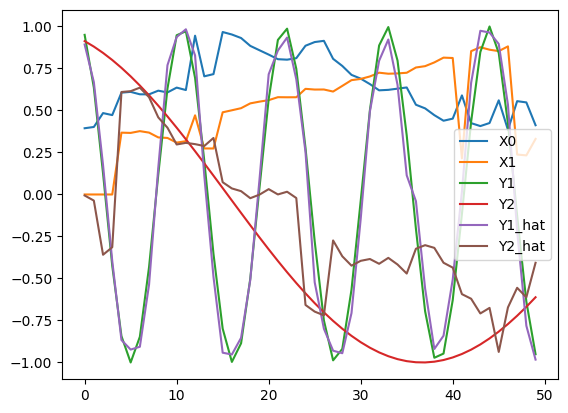

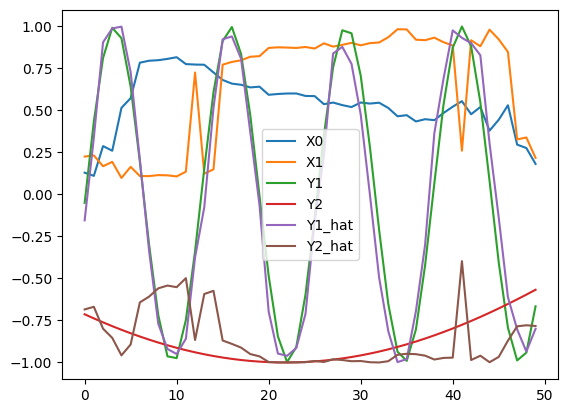

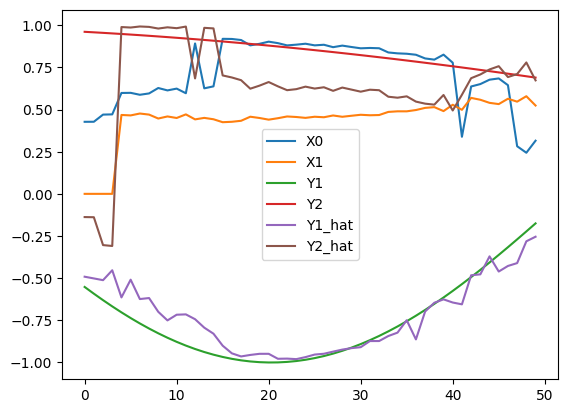

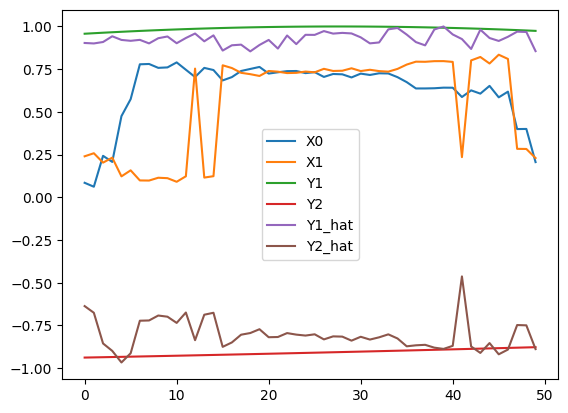

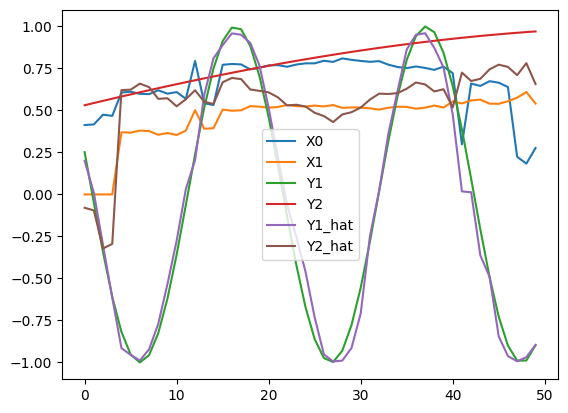

In [56]:
num_samples = 5
samples, givens = generate_samples(num_samples, y_givens)
plot_samples(num_samples, samples, givens)

# Validating the Model

In [57]:
val = torch.load("/kaggle/input/bh-data-2/validation_dataset.pt")

In [58]:
features, labels = val.tensors
features.shape, labels.shape

(torch.Size([3000, 1, 50, 2]), torch.Size([3000, 1, 50, 2]))

In [59]:
Val_Dataset = TensorDataset(features, labels)
val_loader = DataLoader(Val_Dataset, batch_size=batch_size, shuffle=True)

In [60]:
with torch.no_grad():
    
    Model.eval()
    val_x_loss = 0
    val_y_loss = 0
    val_KLD = 0
    val_loss = 0
    
    for batch in tqdm(val_loader):
        x0_x1, y1_y2 = batch
        x0_x1 = x0_x1.to(device)
        y1_y2 = y1_y2.to(device)
        
        z_mu, z_log_var, x_hat = Model(x0_x1, y1_y2)
        
        
        x_loss, KLD, y_loss, loss = loss_function(x0_x1, x_hat, z_mu, z_log_var, y1_y2)
        x_loss, KLD, y_loss, loss = x_loss.to(device), KLD.to(device), y_loss.to(device), loss.to(device)
        
        val_x_loss += x_loss.item()
        val_y_loss += y_loss.item()
        val_KLD += KLD.item()
        val_loss += loss.item()
        
val_x_loss /= len(val_loader)
val_y_loss /= len(val_loader)
val_KLD /= len(val_loader)
val_loss /= len(val_loader)
print(f'Loss: {val_loss} KLD: {val_KLD} y_loss: {val_y_loss} x_loss: {val_x_loss}')

  0%|          | 0/94 [00:00<?, ?it/s]

Loss: 0.5820517565341706 KLD: 0.0014352671643520923 y_loss: 0.13440732475607953 x_loss: 0.4462091653270924


# Creating Samples for Submission

In [61]:
score = torch.load("/kaggle/input/bh-data-2/scoring_dataset.pt")

In [62]:
x_sc, y_sc = score.tensors
x_sc.shape, y_sc.shape

(torch.Size([50, 1, 50, 2]), torch.Size([50, 1, 50, 2]))

In [63]:
Model.eval()
x0_x1 = torch.tensor([])
x0_x1 = x0_x1.to(device)
y1_y2 = torch.tensor([])
y1_y2 = y1_y2.to(device)

for i in range(50):
    x_sc_1, y_sc_1 = x_sc[i,:,:,:],y_sc[i,:,:,:]
    x_sc_1 = torch.unsqueeze(x_sc_1, dim=0)
    y_sc_1 = torch.unsqueeze(y_sc_1, dim=0)
    
    x_sc_1 = x_sc_1.to(device)
    y_sc_1 = y_sc_1.to(device)
    for j in range(30):
        z_rand = torch.randn(1, 50, 2)
        z_rand = z_rand.to(device)
        z_mu, z_log_var = Model.encoder(torch.unsqueeze(z_rand, dim=0), y_sc_1)
        z = Model.sampling(z_mu, z_log_var) 
        
        sample = Model.decoder(z, y_sc_1)
    
        x0_x1 = torch.cat([sample, x0_x1], dim=0)
        y1_y2 = torch.cat([y1_y2, y_sc_1], dim=0)

In [64]:
x0_x1 = x0_x1.to("cpu")
y1_y2 = y1_y2.to("cpu")

In [65]:
ouput = TensorDataset(x0_x1, y1_y2)

In [66]:
torch.save(ouput,"result_data_2.pt")